# Stato dei lavori

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

Le tipologie di esperimenti sono

* Area fissa: tutti gli esperimenti in un dominio di 10*10 gradi, tali che:
  * hanno passi di griglia 0.02, 0.05, 0.08, 0.1
  * usano un numero di core >= 14
  * il rapporto tra X e Y dei sottodomini è tra 1 e 5
  * il tempo di esecuzione stimato è <= 500 secondi
  
* Area variabile: 1000 esperimenti per ognuno dei 4 domini diversi, tali che:
  * hanno passi di griglia 0.02, 0.05, 0.08, 0.1
  * usano un numero di core >= 14
  * il rapporto tra X e Y dei sottodomini è tra 1 e 5
  * il tempo di esecuzione stimato è <= 500 secondi
  
I tempi registrati sono tre

- `time0`: tempo di setup, che può essere trascurato.
- `time1`: tempo di esecuzione della prima ora di previsione
- `time2`: tempo di esecuzione della seconda ora di previsione

Ogni esperimento è stato eseguito per sole due ore di previsione, in quanto `time1` è significativamente più alto di `time2`, mentre le successive ore hanno valori molto simili: questo permette di ridurre notevolmente i tempi e di poter eseguire, quindi, un numero di esperimenti maggiore. Quindi, l'esecuzione di un modello per `N` ore di previsione può essere calcolata con la formula `time_tot = time0 + time1 + time2 * (N - 1)`, che possiamo approssimare a `time_tot = time1 + time2 * (N - 1)`.

Di seguito, un estratto dei tempi di esecuzione dei modelli operativi COSMO 5M e COSMO 2I, dove possiamo notare il picco iniziale

In [2]:
cosmo_5m_timing = pd.read_csv("cosmo_5M_ope_time.csv", names=["time"])
cosmo_2i_timing = pd.read_csv("cosmo_2I_ope_time.csv", names=["time"])

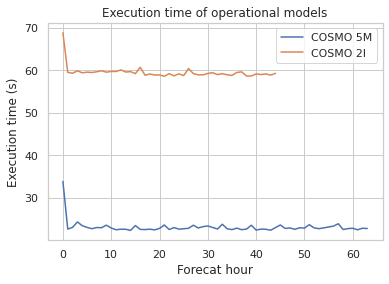

In [3]:
cosmo_5m_timing.time.plot(grid=True, label="COSMO 5M")
cosmo_2i_timing.time.plot(grid=True, label="COSMO 2I")
plt.title("Execution time of operational models")
plt.xlabel("Forecat hour")
plt.ylabel("Execution time (s)")
plt.legend()
plt.show()

La stima è stata fatta secondo una proporzione rispetto al tempo medio della prima ora di COSMO 2I:

```
72 * (20/grid_step) * (ni*nj/403776) * (864/n_procs) * (1 - 0.3*single_precision)
```

Il tempo medio (arrotondato per eccesso) della prima ora di COSMO 2I (72) viene moltiplicato per:

- rapporto tra il passo di griglia di COSMO 2I (20) e il passo di griglia dell'esperimento, in quanto il numero di step di elaborazione sono inveramente proporzionali al passo di griglia
- rapporto tra area di COSMO 2I (403776) e area dell'esperimento
- rapporto tra numero di processi usati da COSMO 2I (864) e numero di processi usati dall'esperimento
- in singola precisione il tempo di esecuzione è circa un 70% (COSMO 2I lavora in doppia precisione)

La formula è volutamente pessimistica in quanto, come detto precedentemente, la prima ora richiede generalmente più tempo delle successive. Questa scelta è motivata dal fatto che, non sapendo a priori la precisione della formula, non si voleva rischiare di dedicare molto più tempo del necessario agli esperimenti.

## Esecuzione degli esperimenti

Lo script [calcolo_combinazioni.py](cosmo_dlp/calcolo_combinazioni.py) genera i file [fixed_area.csv](fixed_area.csv) e [variable_area.csv](variable_area.csv), che contengono le informazioni sugli esperimenti da eseguire.

Lo script [genera_job.py](cosmo_dlp/genera_job.py) converte i file CSV in una struttura a directory per l'esecuzione degli esperimenti su Galileo. Ogni esperimento è in una directory nella forma

    ${x_length}_${y_length}_${grid_step}_${n_nodes}_${n_cores}_${single_precision}_${physics_on}_${nx}_${ny}
    
Il medesimo script genera anche i job che devono essere lanciati per creare i dati iniziali e al contorno, necessari per l'esecuzione delle previsioni.
    
E al suo interno si trovano tutti i file necessari per l'esecuzione del job.

Le directory sono caricate su galileo in `$HOME/experiments/{fixed,variable}_area` (a seconda della tipologia di esperimento). All'interno di ognuna della due directory è anche presente il CSV `jobs.csv` con gli esperimenti associati, in cui è stata aggiunta la colonna `jobdir`, che contiene il path relativo del job.

I job sono lanciati su Galileo (**TODO**: formalizzare e documentare questa parte).

Infine, lo script [raccogli_risultati.py](cosmo_dlp/raccogli_risultati.py) scarica i risultati da Galileo e combina il file `jobs.csv` con il tempo di esecuzione (preso dal file `YUTIMING` nella directory del job).

I due file risultanti sono [fixed_area_results.csv](fixed_area_results.csv) e [variable_area_results.csv](variable_area_results.csv).

## Esperimenti a griglia fissa

In [4]:
df = pd.read_csv("fixed_area_results.csv")
in_keys = ["grid_step", "n_nodes", "n_cores", "single_precision", "subdomain_ratio"]
out_keys = ["time0", "time1", "time2"]
df[in_keys + out_keys].describe()

,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time0,time1,time2
count,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000,5758.000000
mean,35.644321,31.059743,24.473081,0.500000,2.136235,2.716936,24.364647,19.928598
std,21.384913,14.857083,6.927593,0.500043,1.072946,2.028069,21.189187,19.789107
min,20.000000,10.000000,14.000000,0.000000,1.000000,0.440000,1.770000,0.800000
25%,20.000000,18.000000,18.000000,0.000000,1.250000,1.200000,5.410000,3.280000
50%,20.000000,29.000000,24.000000,0.500000,1.800000,2.500000,21.920000,16.250000
75%,50.000000,43.000000,30.000000,1.000000,2.777778,3.487500,34.682500,28.772500
max,100.000000,60.000000,36.000000,1.000000,5.000000,19.950000,154.970000,145.000000


In [5]:
print("Numero di esperimenti eseguiti:", df[df.time0.notnull()].shape[0], "su", df.shape[0])

Numero di esperimenti eseguiti: 5758 su 5758


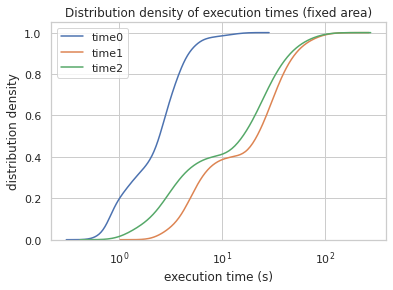

In [6]:
plt.title("Distribution density of execution times (fixed area)")
plt.xscale("log")
sns.kdeplot(data=df, x="time0", cumulative=True, label="time0")
sns.kdeplot(data=df, x="time1", cumulative=True, label="time1")
sns.kdeplot(data=df, x="time2", cumulative=True, label="time2")
plt.xlabel("execution time (s)")
plt.ylabel("distribution density")
plt.legend()
plt.show()

Si può notare come il calcolo usato per stimare i tempi di esecuzione sovrastimi.

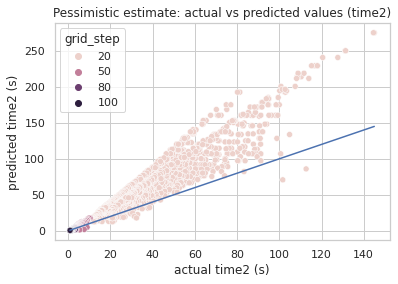

In [7]:
plt.title("Pessimistic estimate: actual vs predicted values (time2)")
plt.plot([df.time2.min(), df.time2.max()], [df.time2.min(), df.time2.max()])
sns.scatterplot(data=df, x="time2", y="estimated_duration", hue="grid_step", legend="full")
plt.ylabel("predicted time2 (s)")
plt.xlabel("actual time2 (s)")
plt.show()

Considerando l'approccio pessimistico, si può usare il valore medio delle ore di previsione successive alla prima (59.8)

In [8]:
df["estimated_duration_2"] = 59.8 * (20/df.grid_step) * (df.ni*df.nj/403776) * (864/df.n_procs) * (1 - 0.3*df.single_precision)

Tuttavia, anche la nuova formula sovrastima.

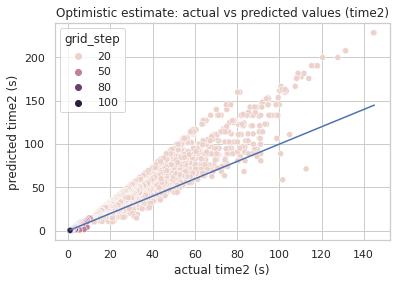

In [9]:
plt.title("Optimistic estimate: actual vs predicted values (time2)")
plt.plot([df.time2.min(), df.time2.max()], [df.time2.min(), df.time2.max()])
sns.scatterplot(data=df, x="time2", y="estimated_duration_2", hue="grid_step", legend="full")
plt.ylabel("predicted time2 (s)")
plt.xlabel("actual time2 (s)")
plt.show()

Anche se non abbiamo ancora tutti i dati, possiamo notare come la variazione del rapporto tra X e Y del sottodominio abbia un effetto sensibile solo nel caso della risoluzione più alta (= basso `grid_step`).

In [10]:
sd_grp_keys = ["grid_step", "n_nodes", "n_cores", "single_precision"]
sd_grp_df = df[df.time0.notnull()].groupby(sd_grp_keys).filter(lambda d: len(d) > 1).groupby(sd_grp_keys).time2.agg(["count", "min", "max", "mean", "std"]).sort_values("std").reset_index()
sd_grp_df

,grid_step,n_nodes,n_cores,single_precision,count,min,max,mean,std
0,100,20,18,1,2,0.84,0.84,0.840,0.000000
1,50,38,36,1,2,2.05,2.05,2.050,0.000000
2,50,16,26,1,2,3.31,3.31,3.310,0.000000
3,50,44,18,1,2,2.18,2.18,2.180,0.000000
4,50,48,14,0,2,3.29,3.29,3.290,0.000000
...,...,...,...,...,...,...,...,...,...
1741,20,10,24,1,4,53.16,77.28,59.775,11.685947
1742,20,18,22,0,4,55.77,91.25,64.775,17.650687
1743,20,16,18,0,4,68.89,104.86,78.335,17.689195
1744,20,16,34,0,2,56.05,101.63,78.840,32.229927


## Esperimenti a griglia variabile

In [11]:
df = pd.read_csv("variable_area_results.csv")
in_keys = ["x_length", "y_length", "grid_step", "n_nodes", "n_cores", "single_precision", "subdomain_ratio"]
out_keys = ["time0", "time1", "time2"]
df[in_keys + out_keys].describe()

,x_length,y_length,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,time0,time1,time2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,23280.000000,15680.000000,49.864000,32.754200,24.910000,0.494200,2.234769,4.688896,41.390122,33.475996
std,14117.275215,4941.101385,28.491119,14.425249,6.908766,0.500016,1.094570,4.322076,58.844516,53.256584
min,7200.000000,10000.000000,20.000000,10.000000,14.000000,0.000000,1.000000,0.470000,1.780000,0.840000
25%,10000.000000,12000.000000,20.000000,20.000000,18.000000,0.000000,1.333333,1.717500,6.380000,3.180000
50%,23200.000000,14400.000000,50.000000,32.000000,24.000000,0.000000,1.909091,3.220000,14.005000,8.390000
75%,30000.000000,18000.000000,80.000000,45.000000,30.000000,1.000000,2.902273,6.140000,49.470000,39.725000
max,46000.000000,24000.000000,100.000000,60.000000,36.000000,1.000000,5.000000,32.790000,418.450000,383.190000


Per poter lanciare gli esperimenti, è necessario avere dei dati iniziali in formato NetCDF, che devono essere scaricati manualmente da un servizio web di DWD.

Gli esperimenti sono inoltre limitati ad un'area di 48x25 gradi, in quanto i suddetti dati devono poi essere combinati con i dati di analisi in formato GRIB, che Arpae-SIMC possiede solo all'interno di un'area specifica. Ogni esperimento con griglia variabile è quindi limitato in questo dominio, vale a dire un'area che copre all'incirca tutto il Mediterraneo. Nel sistema ruotato in uso, la longitudine è nel range [-25.,23] e la latitudine in [-13,12]: quindi l'area massima è di 48 x 25 gradi.

Purtroppo, è necessario ridurre lievemente la dimensione dell'area, in quanto pare che il programma che combina i dati estende lievemente l'area - e quindi genera un errore.

Ho considerato quindi il range [-24.8, 22.8], [-12.9, 11.9], a cui corrisponde un'area di 47.6 x 24.8 gradi. L'area considerata deve essere poi diminuita ulteriormente di un delta pari al passo di griglia per necessità del programma di generazione dei dati iniziali. Ad esempio, nel caso di passo 0.1 diventano [24.7, 22.7] e [-12.8, 11.8] e area 47.4 x 24.6 gradi.

Si usano i medesimi passi di griglia individuati negli esperimenti a griglia fissa: i modelli operativi usano delle risoluzioni molto simili (circa 0.5 per le coarse e 0.2 per le high resolution).

La scelta degli esperimenti è stata fatta casualmente, prendendone 1000 per ogni griglia tra tutte le possibili combinazioni: ovviamente, i passi di griglia più piccoli saranno maggiormente rappresentati in quanto il numero di combinazioni è maggiore.

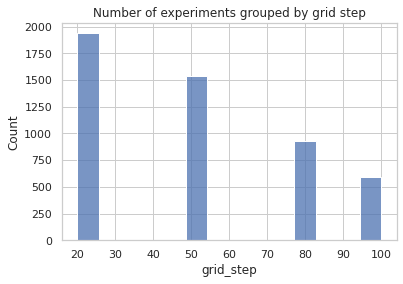

In [12]:
sns.histplot(data=df, x="grid_step")
plt.title("Number of experiments grouped by grid step")
plt.show()

Le griglie sono state scelte in modo da essere uniformi in termini di
- valori latitudine
- valori longitudine
- rapporto tra longitudine e latitudine
- area della griglia

Solo lungo la longitudine abbiamo due valori molto prossimi (7.2 e 10.0). Tuttavia, le due griglie differiscono, soprattutto in termini di latitudine e rapporto tra i lati.

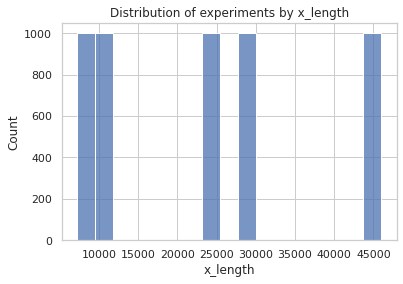

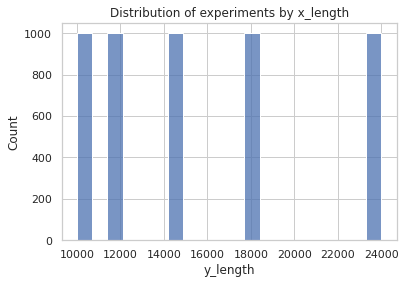

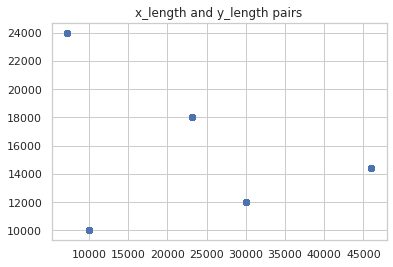

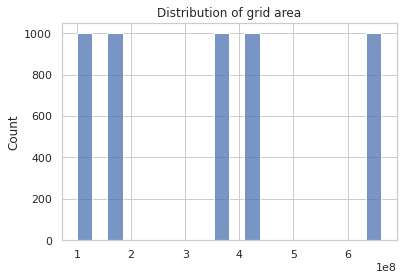

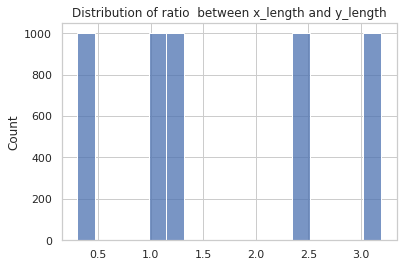

In [13]:
plt.title("Distribution of experiments by x_length")
sns.histplot(df.x_length)
plt.show()
plt.title("Distribution of experiments by x_length")
sns.histplot(df.y_length)
plt.show()
plt.title("x_length and y_length pairs")
plt.scatter(df.x_length, df.y_length)
plt.show()
plt.title("Distribution of grid area")
sns.histplot(df.x_length * df.y_length)
plt.show()
plt.title("Distribution of ratio  between x_length and y_length")
sns.histplot(df.x_length / df.y_length)
plt.show()

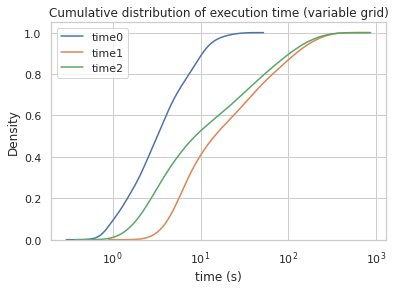

In [14]:
plt.title("Cumulative distribution of execution time (variable grid)")
plt.xscale("log")
sns.kdeplot(df.time0, cumulative=True, label="time0")
sns.kdeplot(df.time1, cumulative=True, label="time1")
sns.kdeplot(df.time2, cumulative=True, label="time2")
plt.xlabel("time (s)")
plt.legend()
plt.show()

Come anticipato, si può notare che il valore `time0` è un tempo di setup del modello che potrebbe essere trascurato, in quanto al massimo 32 secondi e non più di 6 secondi nel 75% dei casi.

In [15]:
df.time0.describe()

count    5000.000000
mean        4.688896
std         4.322076
min         0.470000
25%         1.717500
50%         3.220000
75%         6.140000
max        32.790000
Name: time0, dtype: float64

Si può notare come la formula per la stima del tempo di esecuzione sovrastimi.

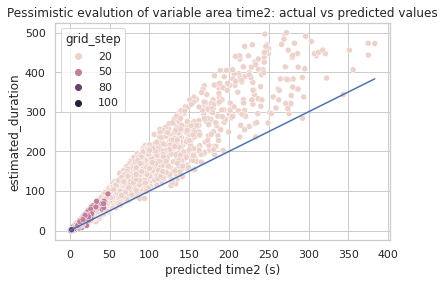

In [16]:
plt.title("Pessimistic evalution of variable area time2: actual vs predicted values")
plt.plot([df.time2.min(), df.time2.max()], [df.time2.min(), df.time2.max()])
sns.scatterplot(data=df, x="time2", y="estimated_duration", hue="grid_step", legend="full")
plt.xlabel("actual time2 (s)")
plt.xlabel("predicted time2 (s)")
plt.show()

Anche qui la formula più ottimistica sovrastima:

In [17]:
df["estimated_duration_2"] = 59.8 * (20/df.grid_step) * (df.ni*df.nj/403776) * (864/df.n_procs) * (1 - 0.3*df.single_precision)

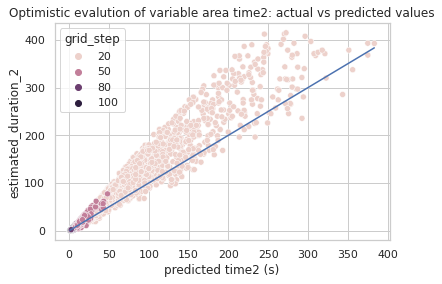

In [18]:
plt.title("Optimistic evalution of variable area time2: actual vs predicted values")
plt.plot([df.time2.min(), df.time2.max()], [df.time2.min(), df.time2.max()])
sns.scatterplot(data=df, x="time2", y="estimated_duration_2", hue="grid_step", legend="full")
plt.xlabel("actual time2 (s)")
plt.xlabel("predicted time2 (s)")
plt.show()

Il rapporto tra dimensione X e Y dei sottodomini, tuttavia, non pare essere particolarmente determinante nell'influenzare il tempo di esecuzione. Vediamo una variazione sensibile solo nel caso delle griglie più grandi e con alta risoluzione (= basso `grid_step`), ma in un numero molto limitato. Nel caso invece di bassa risoluzione, abbiamo addirittura casi in cui la variazione è nulla.

In [19]:
sd_grp_keys = ["x_length", "y_length", "grid_step", "n_nodes", "n_cores", "single_precision"]
sd_grp_df = df.groupby(sd_grp_keys).filter(lambda d: len(d) > 1).groupby(sd_grp_keys).time2.agg(["count", "min", "max", "mean", "std"]).sort_values("std").reset_index()
sd_grp_df

,x_length,y_length,grid_step,n_nodes,n_cores,single_precision,count,min,max,mean,std
0,23200,18000,100,14,24,1,2,2.09,2.09,2.090,0.000000
1,7200,24000,80,12,28,1,2,1.91,1.91,1.910,0.000000
2,30000,12000,100,14,24,0,2,2.88,2.88,2.880,0.000000
3,7200,24000,50,30,18,1,2,4.02,4.02,4.020,0.000000
4,46000,14400,80,36,24,1,2,2.73,2.73,2.730,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
513,30000,12000,20,14,30,0,2,241.48,262.54,252.010,14.891669
514,23200,18000,20,15,24,0,2,286.18,307.43,296.805,15.026019
515,23200,18000,20,15,30,0,2,261.72,285.33,273.525,16.694791
516,46000,14400,20,46,36,0,2,133.45,157.12,145.285,16.737218


## Modelli per la previsione dei tempi di esecuzione

Come già descritto, il tempo di esecuzione della prima ora di previsione (`time1`) è sensibilmente più alto e i tempi di esecuzione delle ore successive sono molto simili (quindi simili a `time2`). Di conseguenza, il tempo di esecuzione per N ore di previsione è pari a: `time0` + `time1` + `time2 * (N - 1)`. Generalmente, COSMO viene lanciato per un numero di ore compreso tra 18 e 120. Si decide dunque di considerare un numero di ore di previsione `N` tra 1 e 200.

Il lavoro prevede l'uso dei dataset generati nella prima fase:

* Dataset a griglia fissa (DGF)
* Dataset a griglia variabile (DGV)

E i seguenti predittori, uno per ogni dataset (per evitare overfitting, in quanto il risultato sarebbe sbilanciato a favore di DGF):

* Predizione del tempo `time1` (PT1)
* Predizione del tempo `time2` (PT2)
* Predizione del tempo `time1 + time2 * (N-1)` (PTTOT)

I sei modelli risultanti sono quindi:
- DGF-PT1
- DGF-PT2
- DGF-PTTOT
- DGV-PT1
- DGV-PT2
- DGV-PTTOT

Ogni modello sarà sottoposto a tuning degli iperparametri:

- La metrica scelta è la MSE del validation set, in quanto si vogliono privilegiare i job più lunghi e si vogliono, al tempo stesso, evitare outlier. Si considera il valore migliore tra le epoch.
- Viene usata la k-fold cross validation (con K=10), quindi la metrica è il risultato della media delle 10 esecuzioni.
- Bayesian Optimization ([hyperopt](https://hyperopt.github.io/hyperopt/))
- Gli iperparametri considerati sono (si veda [cosmo_dlp/hpopt.py](cosmo_dlp/hpopt.py)):
  - Numero di hidden layer
  - Numero di neuroni per ogni hidden layer
  - Dropout per ogni hidden layer
  - Batch size
  - Weight decay
  - Loss function
  - Numero di epoch
  
Una volta selezionati gli iperparametri, il modello verrà riaddestrato con tutti i dati del training set, salvato e infine testato con i dati del test set.
  
Si potranno poi confrontare i seguenti risultati, sempre per ogni tipo di dataset:

* `PT2(x) * N`
* `PT1(x) + PT2(x) * (N - 1)`
* `PTTOT(x)`
* Funzione di stima (versione ottimistica e pessimistica) usata inizialmente per quantificare il tempo degli esperimenti

Si valuteranno anche i modelli per DGF come predittori per DGV, mediante un preprocessamento dei dati di ingresso: il numero di nodi reale viene diviso per il rapporto tra l'area della griglia variabile e l'area della griglia fissa: ad esempio, se si vuole prevedere il tempo di esecuzione di una griglia che è il doppio di quella fissa, basta dividere per due il numero di nodi usati. Ovviamente, questa è una approssimazione: i calcoli sono fatti in parallelo per ogni nodo, ma i sottodomini contigui devono comunicare i risultati attraverso passaggio di messaggi (e quindi ci saranno in realtà un numero maggiore di comunicazioni in una griglia più ampia).

Infine, un altro aspetto interessante è scoprire quali parametri influenzano maggiormente i modelli (e quanto).

### Considerazioni prelininari sulla complessità del problema (DGV-PT2)

Prima di effettuare il tuning degli iperparametri, è necessario partire da modelli semplici, in quanto il nostro problema potrebbe essere risolto con strumenti meno complessi di un modello DL.

Viene preso in considerazione il problema DGV-PT2 e verranno valutati i seguenti modelli:

* Previsione ottimistica (PO)
* Regressione lineare (LR)
* NN con 1 hidden layer (NN1)
* NN con 2 hidden layer (NN2)

I modelli sono confrontati senza tuning per fare una rapida valutazione preliminare. 

In [20]:
train_set = pd.read_csv("data/input/DGV_PT2_train.csv")
test_set = pd.read_csv("data/input/DGV_PT2_test.csv")

In [21]:
from sklearn.preprocessing import MinMaxScaler
import torch

scaler = MinMaxScaler().fit(train_set.iloc[:, :-1])
train_inputs = torch.tensor(scaler.transform(train_set.iloc[:, :-1])).float()
train_outputs = torch.tensor(np.log(train_set[["time2"]].values)).float()
test_inputs = torch.tensor(scaler.transform(test_set.iloc[:, :-1])).float()
test_outputs = torch.tensor(np.log(test_set[["time2"]].values)).float()

Il primo modello è la previsione ottimistica (PO): come già anticipato, questa previsione calcola il tempo di esecuzione di un job facendo una proporzione con i parametri del modello operativo COSMO-I2.

In [22]:
def optimistic_estimate(df):
    ni = df.x_length / df.grid_step
    nj = df.y_length / df.grid_step
    n_procs = df.n_nodes * df.n_cores
    return 59.8 * (20/df.grid_step) * (ni*nj/403776) * (864/n_procs) * (1 - 0.3*df.single_precision)

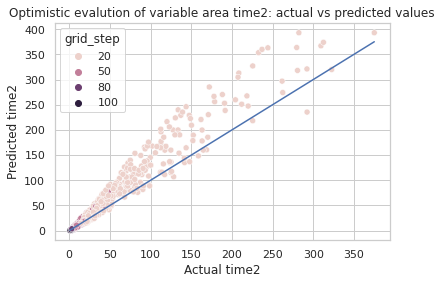

In [23]:
test_set["po_pred"] = optimistic_estimate(test_set)
test_set["po_aerr"] = (test_set.time2 - test_set.po_pred).abs()
test_set["po_rerr"] = test_set.po_aerr / test_set.time2
test_set["po_serr"] = (test_set.time2 - test_set.po_pred) ** 2

plt.title("Optimistic evalution of variable area time2: actual vs predicted values")
plt.plot([test_set.time2.min(), test_set.time2.max()], [test_set.time2.min(), test_set.time2.max()])
sns.scatterplot(data=test_set, x="time2", y="po_pred", hue="grid_step", legend="full")
plt.xlabel("Actual time2")
plt.ylabel("Predicted time2")
plt.show()

Partiamo da un modello molto semplice, quindi una semplice regressione lineare (LR). Si può notare come il modello non stimi correttamente i run più lunghi.

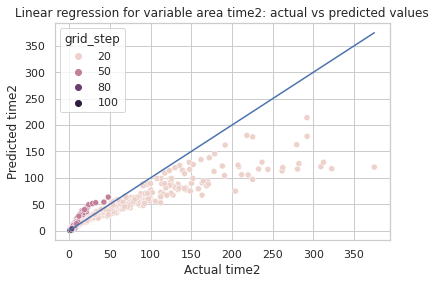

In [24]:
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

torch.manual_seed(0)

reg = LinearRegression()
reg = reg.fit(train_inputs, train_outputs)
test_set["lr_pred"] = np.exp(reg.predict(test_inputs))
test_set["lr_aerr"] = (test_set.time2 - test_set.lr_pred).abs()
test_set["lr_rerr"] = test_set.lr_aerr / test_set.time2
test_set["lr_serr"] = (test_set.time2 - test_set.lr_pred) ** 2

plt.title("Linear regression for variable area time2: actual vs predicted values")
plt.plot([test_set.time2.min(), test_set.time2.max()], [test_set.time2.min(), test_set.time2.max()])
sns.scatterplot(data=test_set, x="time2", y="lr_pred", hue="grid_step", legend="full")
plt.xlabel("Actual time2")
plt.ylabel("Predicted time2")
plt.show()

Un secondo modello prevede l'uso di una single hidden layer (NN1L). Usiamo `ReLU` come funzione di attivazione, `MSE` come loss function e `Adam` come optimizer.

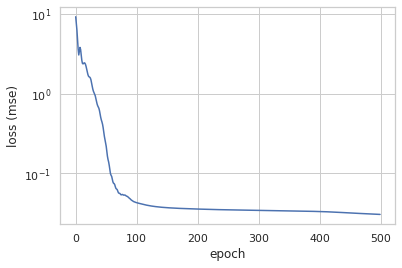

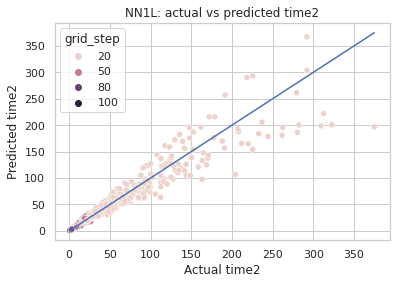

In [25]:
net = nn.Sequential(
    nn.Linear(train_inputs.shape[1], 14),
    nn.ReLU(),
    nn.Linear(14, 1),
)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.05)

losses = []
net.train()
for epoch in range(500):
    pred = net(train_inputs)
    loss = criterion(pred, train_outputs)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(losses)
plt.yscale("log")
plt.ylabel("loss (mse)")
plt.xlabel("epoch")
plt.show()
    
net.eval()
with torch.no_grad():
    pred = net(test_inputs)
    nn1l_res = test_set.copy()
    test_set["nn1l_pred"] = np.exp(pred.numpy())
    test_set["nn1l_aerr"] = (test_set.time2 - test_set.nn1l_pred).abs()
    test_set["nn1l_rerr"] = test_set.nn1l_aerr / test_set.time2
    test_set["nn1l_serr"] = (test_set.time2 - test_set.nn1l_pred) ** 2

plt.title("NN1L: actual vs predicted time2")
plt.plot([test_set.time2.min(), test_set.time2.max()], [test_set.time2.min(), test_set.time2.max()])
sns.scatterplot(data=test_set, x="time2", y="nn1l_pred", hue="grid_step", legend="full")
plt.xlabel("Actual time2")
plt.ylabel("Predicted time2")
plt.show()

Aggiungiamo un altro hidden layer (NN2L).

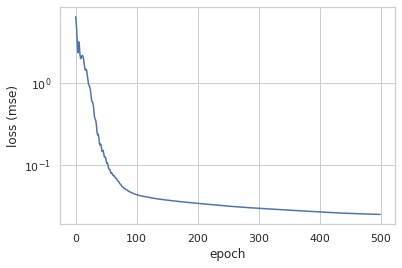

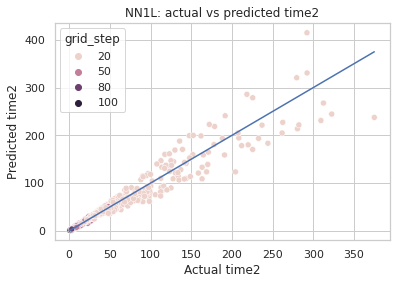

In [26]:
net = nn.Sequential(
    nn.Linear(train_inputs.shape[1], 14),
    nn.ReLU(),
    nn.Linear(14, 7),
    nn.ReLU(),
    nn.Linear(7, 1),
)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.05)

losses = []
net.train()
for epoch in range(500):
    pred = net(train_inputs)
    loss = criterion(pred, train_outputs)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.plot(losses)
plt.yscale("log")
plt.ylabel("loss (mse)")
plt.xlabel("epoch")
plt.show()
    
net.eval()
with torch.no_grad():
    pred = net(test_inputs)
    nn1l_res = test_set.copy()
    test_set["nn2l_pred"] = np.exp(pred.numpy())
    test_set["nn2l_aerr"] = (test_set.time2 - test_set.nn2l_pred).abs()
    test_set["nn2l_rerr"] = test_set.nn2l_aerr / test_set.time2
    test_set["nn2l_serr"] = (test_set.time2 - test_set.nn2l_pred) ** 2

plt.title("NN1L: actual vs predicted time2")
plt.plot([test_set.time2.min(), test_set.time2.max()], [test_set.time2.min(), test_set.time2.max()])
sns.scatterplot(data=test_set, x="time2", y="nn2l_pred", hue="grid_step", legend="full")
plt.xlabel("Actual time2")
plt.ylabel("Predicted time2")
plt.show()

Sotto possiamo vedere l'andamento degli errori per PO, LR, NN1L e NN2L. Possiamo notare che:
* NN2L è il modello migliore
* PO si comporta in modo molto simile a LR
* PO e LR si comportano sensibilmente peggio, evidenziando una caratteristica di non linearità intrinseca nel problema

La supposizione che si può fare è che NN1L e NN2L abbiano imparato a valutare alcuni aspetti che influenzano il tempo di esecuzione che sono intrinsecamente impossibili per PO:

* Suddivisione dei processi in nodi e core per nodo
* Aspect ratio dei sottodomini
* Aspect ratio del dominio

In [27]:
print("Errore assoluto")
test_set[["po_aerr", "lr_aerr", "nn1l_aerr", "nn2l_aerr"]].describe()

Errore assoluto


,po_aerr,lr_aerr,nn1l_aerr,nn2l_aerr
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.802852,10.216071,5.409639,4.612583
std,19.238842,23.209600,13.617268,11.723999
min,0.004431,0.002782,0.000072,0.000670
25%,0.499971,0.789871,0.267752,0.267141
50%,1.513882,2.676099,0.865722,0.674311
75%,9.459861,8.246888,3.877851,2.449395
max,122.857660,254.620388,178.108486,137.443889


In [28]:
print("Errore relativo")
test_set[["po_rerr", "lr_rerr", "nn1l_rerr", "nn2l_rerr"]].describe()

Errore relativo


,po_rerr,lr_rerr,nn1l_rerr,nn2l_rerr
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.271033,0.388431,0.137480,0.118815
std,0.194615,0.318654,0.098100,0.088639
min,0.000649,0.000376,0.000002,0.000034
25%,0.108545,0.131811,0.058978,0.046064
50%,0.236828,0.322604,0.121300,0.102739
75%,0.404457,0.551741,0.201536,0.175868
max,0.899692,1.496963,0.548309,0.527111


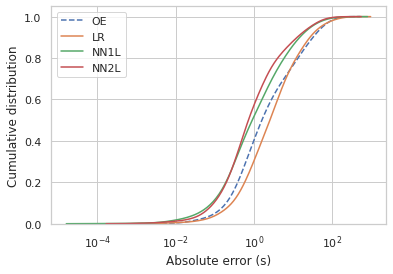

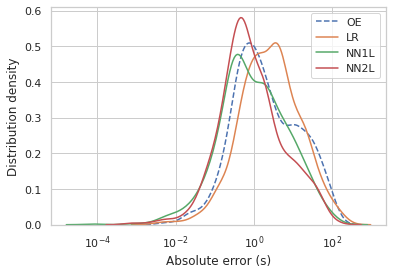

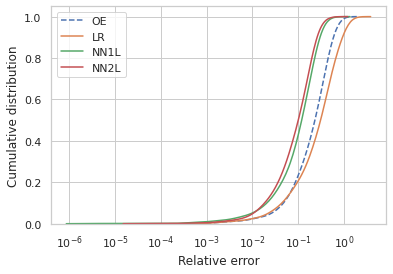

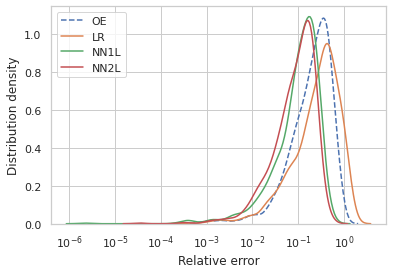

In [29]:
sns.kdeplot(data=test_set, x="po_aerr", cumulative=True, log_scale=True, label="OE", linestyle="--")
sns.kdeplot(data=test_set, x="lr_aerr", cumulative=True, log_scale=True, label="LR")
sns.kdeplot(data=test_set, x="nn1l_aerr", cumulative=True, log_scale=True, label="NN1L")
sns.kdeplot(data=test_set, x="nn2l_aerr", cumulative=True, log_scale=True, label="NN2L")
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.legend()
plt.show()
sns.kdeplot(data=test_set, x="po_aerr", cumulative=False, log_scale=True, label="OE", linestyle="--")
sns.kdeplot(data=test_set, x="lr_aerr", cumulative=False, log_scale=True, label="LR")
sns.kdeplot(data=test_set, x="nn1l_aerr", cumulative=False, log_scale=True, label="NN1L")
sns.kdeplot(data=test_set, x="nn2l_aerr", cumulative=False, log_scale=True, label="NN2L")
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.legend()
plt.show()

sns.kdeplot(data=test_set, x="po_rerr", cumulative=True, log_scale=True, label="OE", linestyle="--")
sns.kdeplot(data=test_set, x="lr_rerr", cumulative=True, log_scale=True, label="LR")
sns.kdeplot(data=test_set, x="nn1l_rerr", cumulative=True, log_scale=True, label="NN1L")
sns.kdeplot(data=test_set, x="nn2l_rerr", cumulative=True, log_scale=True, label="NN2L")
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.legend()
plt.show()
sns.kdeplot(data=test_set, x="po_rerr", cumulative=False, log_scale=True, label="OE", linestyle="--")
sns.kdeplot(data=test_set, x="lr_rerr", cumulative=False, log_scale=True, label="LR")
sns.kdeplot(data=test_set, x="nn1l_rerr", cumulative=False, log_scale=True, label="NN1L")
sns.kdeplot(data=test_set, x="nn2l_rerr", cumulative=False, log_scale=True, label="NN2L")
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.show()

### Considerazioni sui modelli PTTOT

I modelli DGV-PTTOT e DGF-PTTOT considerano un solo output, dato dalla somma del tempo di esecuzione della prima ora di previsione e del tempo di esecuzione della seconda ora di previsione, moltiplicata per il numero di ore di previsione meno uno. Questo comporta la generazione di un nuovo dataset a partire da quello originale, in cui per ogni record ne vengono generati 140, cioè il numero di possibili ore di previsione nel range (1, 140). Di conseguenza, si rende necessario introdurre un nuovo parametro `n_hours`.

In [30]:
df = pd.read_csv("variable_area_results.csv")
in_keys = ["x_length", "y_length", "grid_step", "n_nodes", "n_cores", "single_precision", "subdomain_ratio", "n_hours"]
df_list = []
for n in range(1, 140):
    df_temp = df.copy()
    df_temp["n_hours"] = n
    df_temp["time_tot"] = df_temp["time1"] + df_temp["time2"] * (n - 1)
    df_list.append(df_temp)
    
df = pd.concat(df_list)[in_keys + ["time_tot"]]
df.describe()

,x_length,y_length,grid_step,n_nodes,n_cores,single_precision,subdomain_ratio,n_hours,time_tot
count,695000.000000,695000.000000,695000.00000,695000.000000,695000.00000,695000.000000,695000.000000,695000.000000,695000.000000
mean,23280.000000,15680.000000,49.86400,32.754200,24.91000,0.494200,2.234769,70.000000,2351.233846
std,14115.873572,4940.610805,28.48829,14.423816,6.90808,0.499967,1.094461,40.124834,4506.043629
min,7200.000000,10000.000000,20.00000,10.000000,14.00000,0.000000,1.000000,1.000000,1.780000
25%,10000.000000,12000.000000,20.00000,20.000000,18.00000,0.000000,1.333333,35.000000,185.657500
50%,23200.000000,14400.000000,50.00000,32.000000,24.00000,0.000000,1.909091,70.000000,510.080000
75%,30000.000000,18000.000000,80.00000,45.000000,30.00000,1.000000,2.902273,105.000000,2296.695000
max,46000.000000,24000.000000,100.00000,60.000000,36.00000,1.000000,5.000000,139.000000,53298.670000


### Hyperparameter tuning

Prima di effettuare il tuning, i dataset sono divisi in training set e test set (hold-out) per evitare data leakage: quest'ultimo sarà usato solo ed esclusivamente per valutare le prestazioni del modello. Lo script [cosmo_dlp/split_datasets.py](cosmo_dlp/split_datasets.py) si occupa di generare i due set, uno per ogni modello.

Lo script [cosmo_dlp/hpopt.py](cosmo_dlp/hpopt.py) si occupa di fare il tuning degli iperparametri dei sei modelli. I vari esperimenti sono salvati nella directory `data/hpopt`.

La metrica di riferimento è il valore migliore, tra tutte le epoch, del RMSE (in secondi) sul validation set (media dei 10 valori del 10-fold cross validation).

Viene poi estratto il modello migliore, che viene riaddestrato con tutti i dati del training set e poi viene valutato usando il test set. Lo script [cosmo_dlp/save_model.py](cosmo_dlp/save_model.py) si occupa di tutta la catena fino alla produzione di un file csv contenente il test set, a cui viene aggiunta la colonna con i valori predetti.

### Esperimenti DGV_PT2
Le configurazioni degli esperimenti sono in `data/experiments`. Ogni esperimento usa 10 fold cross validation e i grafici sono i valori mediati.

Esperimento 0001: batch gradient, learning rate 0.1, due hidden layers (14 e 7). Intorno alla epoch 700 il modello pare convergere e i picchi successivi sono frutto dell'alto learning rate, che non permette di trovare un minimo migliore.

In [31]:
!cat data/experiments/DGV_PT2/0001.yml

batch: full
epochs: 1000
kfold: 10
loss: mse
model:
  layers:
    - size: 14
      dropout: 0.0
    - size: 7
      dropout: 0.0
optimizer:
  name: adam
  lr: 0.1
  weight_decay: 0.0


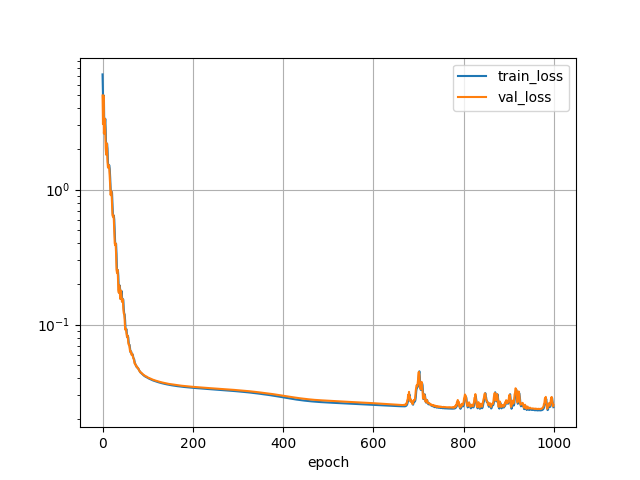

In [32]:
from IPython.display import display, Image
display(Image(filename='data/experiments/DGV_PT2/0001.png'))

Esperimento 0002: provo ad usare un mini-batch gradient di 64: il mini-batch introduce rumore, probabilmente perché, a seconda del sottoinsieme di dati considerati, i pesi sono aggiornati in modo più o meno favorevole. Tuttavia, proprio questi picchi, probabilmente, permettono di uscire dal minimo locale in cui si trovava usando il batch gradient. Il modello converge molto più rapidamente.

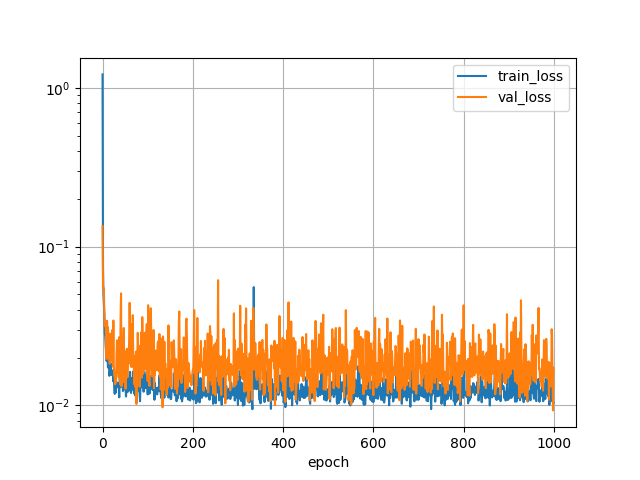

In [33]:
from IPython.display import display, Image
display(Image(filename='data/experiments/DGV_PT2/0002.png'))

Esperimento 0003: diminuisco il learning rate da 0.1 a 0.01. Questo comporta una diminuzione delle oscillazioni e della loss function.

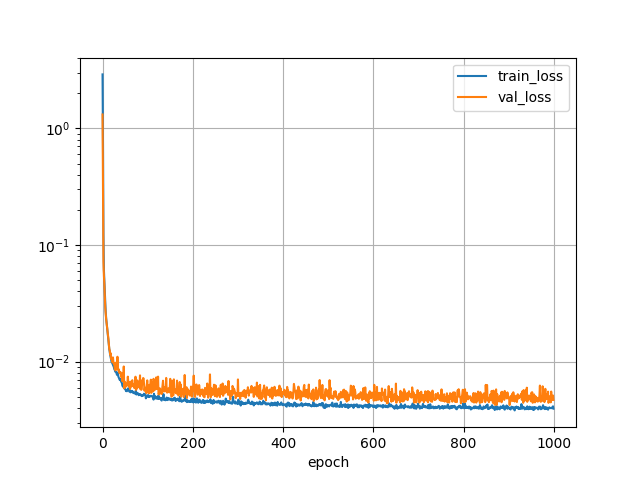

In [34]:
from IPython.display import display, Image
display(Image(filename='data/experiments/DGV_PT2/0003.png'))

Esperimento 0004: torno ad usare il batch gradient (esperimento 0001), con un learning rate dimezzato rispetto a quello di 0001. (da 0.1 a 0.05). Il modello converge meno rapidamente che usando il mini-batch e con risultati lievemente peggiori.

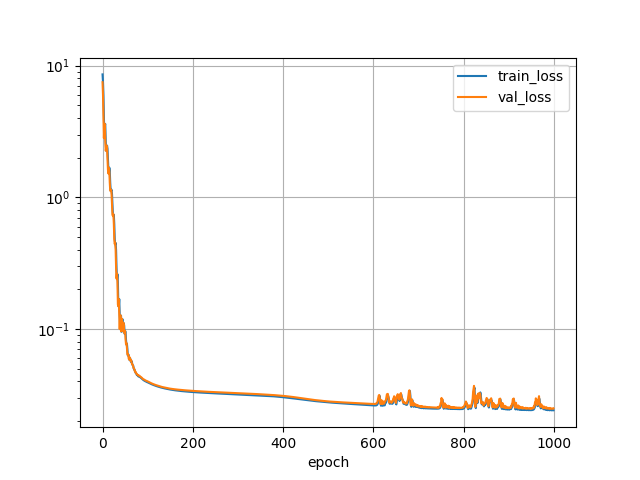

In [35]:
from IPython.display import display, Image
display(Image(filename='data/experiments/DGV_PT2/0004.png'))

Esperimento 0005: torno ad usare il mini-batch gradient (esperimento 0003), con un learning rate dimezzato (da 0.01 a 0.005): l'unico effetto è di far convergere meno rapidamente il modello. 

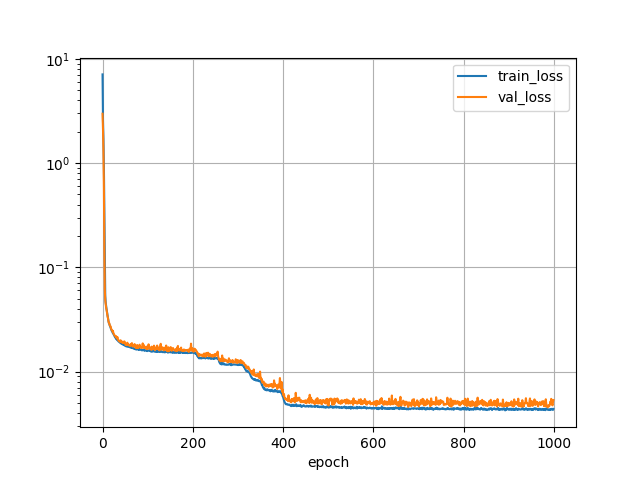

In [36]:
from IPython.display import display, Image
display(Image(filename='data/experiments/DGV_PT2/0005.png'))

Esperimento 0006: dimezzo la dimensione del mini-batch (da 64 a 32) rispetto al precedente esperimento. Non ci sono miglioramenti apprezzabili.

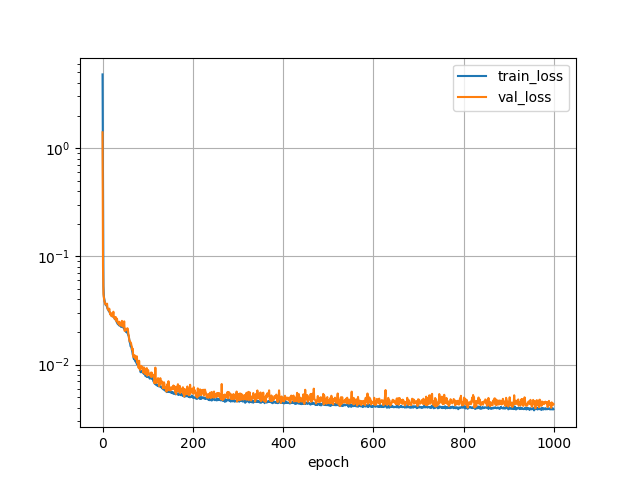

In [37]:
from IPython.display import display, Image
display(Image(filename='data/experiments/DGV_PT2/0006.png'))

Valutazione del modello dell'esperimento 0005: lo addestro con tutto il training set e poi lo valuto sul test set.

In [38]:
from cosmo_dlp.model import CosmoData, CosmoPredictor
import yaml

with open("data/experiments/DGV_PT2/0005.yml") as fp: 
    config = yaml.load(fp, Loader=yaml.FullLoader)
    
data = CosmoData(train_df=pd.read_csv("data/input/DGV_PT2_train.csv"),
                 # uso un solo sample per il validation set perché tanto non lo considero
                 val_df=pd.read_csv("data/input/DGV_PT2_train.csv").sample(1),
                 test_df=pd.read_csv("data/input/DGV_PT2_test.csv"))
model = CosmoPredictor(data.input_size, config)
train_res = model.fit(data, max_epochs=500)
test_res = model.test(data)

In [39]:
!cat data/experiments/DGV_PT2/0005.yml

batch: 64
epochs: 1000
kfold: 10
loss: mse
model:
  layers:
    - size: 14
      dropout: 0.0
    - size: 7
      dropout: 0.0
optimizer:
  name: adam
  lr: 0.005
  weight_decay: 0.0


Il modello ha un buon comportamento soprattutto sull'errore relativo, ma l'errore assoluto è ancora alto.

In [40]:
test_res["abs_err"] = (test_res["target"] - test_res["prediction"]).abs()
test_res["rel_err"] = (test_res["target"] - test_res["prediction"]).abs() / test_res["target"]
test_res.describe()

,target,prediction,abs_err,rel_err
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,30.377750,29.179674,5.601637,0.150443
std,50.418599,44.890328,13.986277,0.103423
min,0.910000,1.286210,0.000576,0.000164
25%,3.085000,3.010034,0.326055,0.066744
50%,7.985000,7.605003,0.959890,0.133358
75%,33.622501,36.413669,4.568382,0.218024
max,375.020081,340.425354,187.741943,0.612004


In [41]:
print("Percentili dell'errore assoluto e relativo")
test_res[["abs_err", "rel_err"]].quantile([0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 1])

Percentili dell'errore assoluto e relativo


,abs_err,rel_err
0.50,0.959890,0.133358
0.75,4.568382,0.218024
0.80,6.286536,0.244024
0.90,13.249827,0.299533
0.95,27.368933,0.335396
0.99,71.939786,0.435722
1.00,187.741943,0.612004


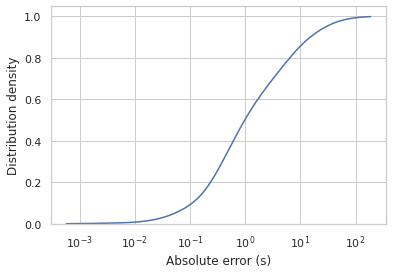

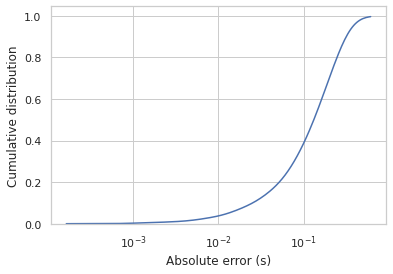

In [42]:
import seaborn as sns
sns.kdeplot(data=test_res, x="abs_err", log_scale=True, cumulative=True, cut=0)
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.show()
sns.kdeplot(data=test_res, x="rel_err", log_scale=True, cumulative=True, cut=0)
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.show()

### Hyperparameter tuning per DGV_PT2

Il codice per il lancio dell'hyperparameter tuning automatico è in [cosmo_dlp/hpopt.py](cosmo_dlp/hpopt.py). I risultati sono salvati in `data/hpopt/DGV_PT2.pk`.

In [43]:
import pickle
with open("data/hpopt/DGV_PT2.pk", "rb") as fp:
    trials = pickle.load(fp)
    
print("Numero di esperimenti:", len(trials))

Numero di esperimenti: 1000


In [44]:
import yaml
print("Migliore configurazione:")
best = trials.best_trial
print(yaml.dump(best["result"]["config"]))

Migliore configurazione:
batch: 64
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 49
  - dropout: 0.0
    size: 13
  - dropout: 0.0
    size: 9
optimizer:
  lr: 0.001112253919985314
  name: adam
  weight_decay: 0.02564558837387174



In [45]:
print("RMSE:", best["result"]["loss"], "secondi")

RMSE: 2.4269809452038444 secondi


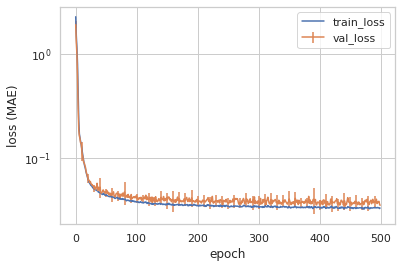

In [46]:
import io
losses = pd.read_csv(io.StringIO(best["result"]["csv"]))
grp = losses.groupby("epoch")
plt.plot(grp.mean().index, grp.mean().train_loss, label="train_loss")
plt.errorbar(grp.mean().index, grp.mean().val_loss, yerr=grp.std().val_loss, errorevery=10, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss (MAE)")
plt.yscale("log")
plt.legend()
plt.show()

Riaddestro il modello usando tutto il training set e poi valuto le sue prestazioni sul test set.

In [47]:
from cosmo_dlp.model import CosmoData, CosmoPredictor
data = CosmoData(
    train_df=pd.read_csv("data/input/DGV_PT2_train.csv"),
    val_df=None,
    test_df=pd.read_csv("data/input/DGV_PT2_test.csv"),
)
model = CosmoPredictor(data.input_size, best["result"]["config"])

In [48]:
res_train = model.fit(data, max_epochs=500)

In [49]:
test_res = model.test(data)
test_res["abs_err"] = (test_res.target - test_res.prediction).abs()
test_res["rel_err"] = ((test_res.target - test_res.prediction).abs()/test_res.target)

In [50]:
rmse = np.sqrt(((test_res.target - test_res.prediction).abs() ** 2).mean())
print("RMSE", rmse)

RMSE 5.861651473296575


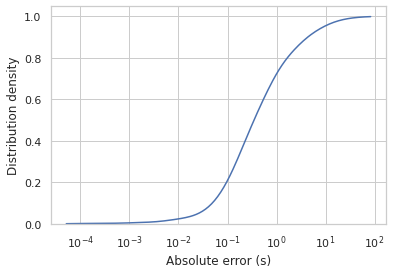

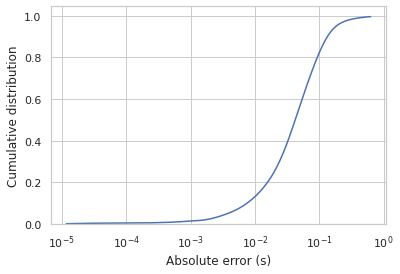

In [51]:
import seaborn as sns
sns.kdeplot(data=test_res, x="abs_err", log_scale=True, cumulative=True, cut=0)
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.show()
sns.kdeplot(data=test_res, x="rel_err", log_scale=True, cumulative=True, cut=0)
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.show()

In [52]:
print("Percentili dell'errore assoluto e relativo")
test_res[["abs_err", "rel_err"]].quantile([0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 1])

Percentili dell'errore assoluto e relativo


,abs_err,rel_err
0.50,0.354706,0.042382
0.75,1.071441,0.079721
0.80,1.530724,0.091401
0.90,3.823396,0.120284
0.95,9.074459,0.160845
0.99,26.160126,0.324200
1.00,83.172028,0.630636


 Il risultato è soddisfacente: se ad esempio il test set fosse stato relativo a dei run su 3 giorni di previsione, avremmo avuto un errore massimo, nel 95% dei casi, di:

In [53]:
from datetime import timedelta
print(timedelta(seconds=test_res.abs_err.quantile(0.95)) * 3 * 24)

0:10:53.361048


## Proseguimento dei lavori

Il lavoro prosegue su più notebook:

* Confronto tra stima pessimistica e stima ottimistica: [Confronto-PP-PO.ipynb](Confronto-PP-PO.ipynb)). Si confrontano le due stime, in modo da scegliere quella più precisa da usare come confronto con i modelli DL.
* Modelli su griglia fissa:
    * Analisi del modello per la previsione di `time1` su griglia fissa (DGF-PT1): [DGF-PT1.ipynb](DGF-PT1.ipynb).
    * Analisi del modello per la previsione di `time2` su griglia fissa (DGF-PT2): [DGF-PT2.ipynb](DGF-PT2.ipynb).
    * Analisi del modello per la previsione di `time_tot` su griglia fissa (DGF-PTTOT): [DGF-PTTOT.ipynb](DGF-PTTOT.ipynb).
    * Analisi del modello per la previsione di `time_tot` su griglia fissa con dataset ridotto (DGF-PTTOT-S): [DGF-PTTOT-S.ipynb](DGF-PTTOT-S.ipynb).
    * Confronto tra DGF-PTTOT-S e DGF-PTTOT: [Confronto-DGF-PTTOT-e-DGF-PTTOT-S.ipynb](Confronto-DGF-PTTOT-e-DGF-PTTOT-S.ipynb).
    * Confronto tra DGF-PT1 + DGF-PT2 e DGF-PTTOT: [Confronto-DGF-PTTOT-e-DGF-PT1-PT2.ipynb](Confronto-DGF-PTTOT-e-DGF-PT1-PT2.ipynb).
* Modelli su griglia variabile:
    * Analisi del modello per la previsione di `time1` su griglia variabile (DGV-PT1): [DGV-PT1.ipynb](DGV-PT1.ipynb).
    * Analisi del modello per la previsione di `time2` su griglia variabile (DGV-PT2): [DGV-PT2.ipynb](DGV-PT2.ipynb).
    * Analisi del modello per la previsione di `time_tot` su griglia variabile (DGV-PTTOT): [DGV-PTTOT.ipynb](DGV-PTTOT.ipynb).
    * Analisi del modello per la previsione di `time_tot` su griglia variabile con dataset ridotto (DGV-PTTOT-S): [DGV-PTTOT-S.ipynb](DGV-PTTOT-S.ipynb).
    * Confronto tra DGV-PTTOT-S e DGV-PTTOT: [Confronto-DGV-PTTOT-e-DGV-PTTOT-S.ipynb](Confronto-DGV-PTTOT-e-DGV-PTTOT-S.ipynb).
    * Confronto tra DGV-PT1 + DGV-PT2 e DGV-PTTOT: [Confronto-DGV-PTTOT-e-DGV-PT1-PT2.ipynb](Confronto-DGV-PTTOT-e-DGV-PT1-PT2.ipynb).
* Confronto tra DGF-PT1 e DGV-PT1 per previsioni su griglia variabile: [Confronto-DGF-PT1-DGV-PT1.ipynb](Confronto-DGF-PT1-DGV-PT1.ipynb).
* Confronto tra DGF-PT2 e DGV-PT2 per previsioni su griglia variabile: [Confronto-DGF-PT2-DGV-PT2.ipynb](Confronto-DGF-PT2-DGV-PT2.ipynb).


## Conclusioni
I seguenti modelli DL hanno buone prestazioni, peraltro sensibilmente migliori (a volte di un ordine di grandezza) delle regressioni lineari e della stima usata inizialmente come riferimento:

- DGF-PT1
- DGF-PT2
- DGF-PTTOT
- DGF-PTTOT-S (con dataset completo)
- DGV-PT1
- DGV-PT2
- DGV-PTTOT
- DGV-PTTOT-S (con dataset completo)

In particolare, i modelli sono stati calibrati in modo da minimizzare il RMSE, in modo da avere un errore più basso nel caso di esecuzioni più lunghe e penalizzare errori alti. Questo ha portato a modelli che hanno

- L'errore relativo minore del 100%
- L'errore relativo dei job più lunghi minore del ~10% (tranne DGF-PT1)
- L'errore relativo medio tra il 2 e il 10% (a seconda del modello)

E possono quindi essere considerati soddisfacenti.

DGV-PT1 e DGV-PT2 hanno prestazioni di poco peggiori rispetto a DGF-PT1 e DGF-PT2 per le previsioni su griglia fissa (si vedano [Confronto-DGF-PT1-DGV-PT1.ipynb](Confronto-DGF-PT1-DGV-PT1.ipynb) e [Confronto-DGF-PT2-DGV-PT2.ipynb](Confronto-DGF-PT2-DGV-PT2.ipynb)), nonostante queste ultime due siano state addestrate con circa lo stesso numero di dati (ma due parametri in meno).

Al tempo stesso, anche DGF-PT1-V e DGF-PT2-V (cioè i modelli a griglia fissa adattati per la previsione su griglia variabile) hanno una precisione soddisfacente per le previsioni su griglia variabile, seppur peggiore di DGV-PT1 e DGV-PT2 (MAPE circa del doppio). La minor precisione dovuta ad una maggiore approssimazione è però compensata da una minore difficoltà nella raccolta dei dati necessari all'addestramento del modello.

La combinazione di DGV-PT1 e DGV-PT2 per la previsione di `time_tot` (cioè il tempo di esecuzione per più ore di previsione) ha prestazioni analoghe a DGV-PTTOT: il paragone non è del tutto esaustivo in quanto il dataset usato per il confronto (e per addestrare DGV-PTTOT) è stato ottenuto generando record sintetici applicando al dataset originale (quello di DGV-PT1 e DGV-PT2) la formula `time_tot = time1 + time2 * (n_hours - 1)`, ma il fatto che il tempo di esecuzione per ogni ora di previsione successiva alla prima fosse uguale (a meno di una fluttuazione casuale) era uno dei presupposti del lavoro. Se le prestazioni sono uguali, DGV-PTTOT usa però un dataset con un parametro in più (`n_hours`) e molti più dati (140 volte) e sarebbe quindi richiesto molto più tempo e risorse di calcolo sia per generare un dataset reale che per calibrare gli iperparametri ed addestrare il modello.

La tipologia di previsione più significativa è quindi la combinazione di DGV-PT1 e DGV-PT2, che può essere usata anche per previsioni su griglia fissa ed è meno onerosa rispetto alla raccolta dei dati di esecuzioni su un numero variabile di ore.

I due modelli DGV-PT1 e DGV-PT2 possono essere utilizzati non solo per pianificare più accuratamente l'esecuzione dei modelli meteo, ma anche per riorganizzare opportunamente le risorse di calcolo in caso di riduzione del numero di nodi del cluster per guasto, per l'introduzione di nuovi task da eseguire oppure per prevedere con precisione il tempo di esecuzione su un basso numero di nodi di recuperi del modello meteo per giorni passati. Inoltre, i modelli DL possono risultare utili per rilevare anomalie (anche a tempo di esecuzione) nel caso in cui l'errore della previsione del tempo di esecuzione sia eccessivo.